In [1]:
# Install required packages
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import pandas as pd
import time
from datetime import date

from scipy.optimize import minimize, check_grad, approx_fprime
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import pyomo environment and setup gurobi solver
import pyomo.environ as pyo
from pyomo.opt import SolverStatus, TerminationCondition
import gurobipy 
solver = pyo.SolverFactory("gurobi_direct")

In [2]:
# Global variables
nr_items = [5,10,20, 40]
smple_sz = 1000
epsilon  = 10e-4
today = date.today()

# Implied variables
nr_trgts = [i + 1 for i in nr_items]
nr_ftres = [2*i for i in nr_items]
nr_ftres_intrcpt = [i + 1 for i in nr_ftres]

In [3]:
# Set seeds
seed = np.random.seed(42)

In [4]:
# Source types: https://github.com/likr/kplib
# Type discription source: https://di.ku.dk/forskning/Publikationer/tekniske_rapporter/tekniske-rapporter-2003/03-08.pdf

f_list   = []

ins_b    = []
ins_v    = []
ins_w    = [] 

# Read in knapsack instance
file_str = 'Instances/' + '00Uncorrelated' + '/s000.kp'
f = open(file_str, "r")
f_list.append(f)
i = 0
lcl_v = []
lcl_w = []
for x in f:
    if i == 2:
        ins_b.append(int(x))
    if i > 3:
        x_split = x.split()
        lcl_v.append(int(x_split[0]))
        lcl_w.append(int(x_split[1]))
    i = i+1

ins_v.append(lcl_v)
ins_w.append(lcl_w)

In [5]:
print([x/ins_b[0] for x in ins_v[0]])
print([x/ins_b[0] for x in ins_w[0]])

[0.05717959128434159, 0.05129246176749222, 0.02848829340912167, 0.01752605223981594, 0.03464609554743538, 0.027405602923264313, 0.05305183380701042, 0.020571119231289754, 0.03227771010962241, 0.03951820273379348, 0.061510353227771014, 0.03417241845987278, 0.01908241981323589, 0.05115712545676005, 0.04188658817160644, 0.016984706996887266, 0.061578021383137095, 0.06651779672486129, 0.05487887400189471, 0.0611043442955745, 0.02104479631885235, 0.04939775341724185, 0.06083367167411016, 0.04628501827040195, 0.03200703748815807, 0.006834483691974556, 0.029435647584246855, 0.041345242928677764, 0.06184869400460143, 0.06543510623900392, 0.0323453782649885, 0.05860062254702937, 0.01766138855054811, 0.05454053322506428, 0.03714981729598051, 0.0010150223304912708, 0.048721071863580996, 0.026999593991067803, 0.0558262281770199, 0.04526999593991068, 0.00013533631073216944, 0.03342806875084585, 0.05873595885776154, 0.01651102990932467, 0.02205981864934362, 0.05893896332385979, 0.012992285830288266,

We consider the continuous knapsack problem, i.e.,
$$
\max c^{\top}z\\
s.t. Az\leq b\\
z\geq 0
$$
Here, $z$ is the decision vector with dimension $n$, nr of items. $c$ is the vector containing all the values of the items, $A$ is the vector containing the weight of the items, and wlog we set $b=1$.
To create explanations $c, A$ are used as features here. Hence there are $2n$ features.

In [6]:
# Continuous LP knapsack
def model_KS_cts(vals, output = 'goal', solver = solver):

    # Define a model
    model = pyo.ConcreteModel('Knapsack continuous model')

    # Declare decision variables
    model.x = pyo.Var(range(int(((len(vals)-1)/2))), domain=pyo.NonNegativeReals, bounds=(0, 1))

    # Declare objective
    model.objective = pyo.Objective(expr = sum(vals[i]*model.x[i] for i in range(int(((len(vals)-1)/2)))),
                                sense = pyo.maximize)

    # Declare constraints
    model.budget = pyo.Constraint(expr = sum(vals[i+int(((len(vals)-1)/2))]*model.x[i] for i in range(int(((len(vals)-1)/2)))) <= vals[-1])

    # Solve
    result = solver.solve(model)

    if output == 'goal':
        return model.objective()

    elif output == 'bounded' or output == 'feasibility':
        return result.solver.termination_condition != TerminationCondition.infeasibleOrUnbounded
    
    elif output == 'decision vector':
        solutions = []
        for i in range(int(((len(vals)-1)/2))):
            solutions.append(pyo.value(model.x[i]))
        return solutions
    
    elif output == 'all':
        solutions = []
        solutions.append(model.objective())
        for i in range(int(((len(vals)-1)/2))):
            solutions.append(pyo.value(model.x[i]))
        return solutions
    
    else:
        raise ValueError("Output not supported for model function")

In [7]:
ins_dict = {}
for i in nr_items:
    ins_dict[str(i)+' items'] = {}
    w_sum = sum(ins_w[0][:i])
    sclr = np.random.uniform(1.1, 1.3)
    ins_lcl_v = [x/w_sum*sclr for x in ins_v[0][:i]]
    ins_lcl_w = [x/w_sum*sclr for x in ins_w[0][:i]]
    ins_lcl_b = [1.0]
    print(sum(ins_lcl_w))
    ins_dict[str(i)+' items']['c,A,b'] = np.concatenate((ins_lcl_v, ins_lcl_w, ins_lcl_b))

features = []
for i in range(len(nr_items)):
    features.append([*range(nr_ftres[i])])

1.1749080237694725
1.2901428612819832
1.2463987883622811
1.2197316968394074


We sample $m=1000$ instances of the knapsack problem. Let $\bold{X}\in\mathbb{R}^{m\times 2n+1}$ denote the full matrix of samples, then $X_{i}=(X_{i1},..., X_{i(2n)}, 1)$ is the $i$-th sample consisting of samples of all $2n$ features and 1 to ensure a value to multiply the intercept with.

Our output vecotr is denoted by $\bold{Y}\in\mathbb{R}^{m\times n+1}$ We want to explain multiple things $y_i=(c_i^{\top}z_i^*, z_i^*)$ is the $n+1$ dimensional output vector with $z_i^*$ the optimal decision vector for sample $i$. We set $y_{ij}=c_i^{\top}z_i^*$ for $j =0$ and $z_{ij}^*$ for $1\leq j\leq n$.

Moreover, we calculate the weight of eacht istance using the rbf-kernel. Set $W\in\mathbb{R}^{m\times m}$ and let $W_{ii}=W_i$ denote weight of $i$-th sample and set $W_{ij}=0$ when $i\neq j$.

In [8]:
# Help functions

# Create samples
def sample_perturbations_normal(orig, ftr_index_list, model_lcl, hyperprm = {}, mean = 0, var = 0.2, size = 1000, feasibility_check = True, bounded_check = True):
    
    org_plus_prtb = [orig]
    cntr = 1
    incr = 1

    while cntr < size:
        orig_with_noise = copy.deepcopy(orig)
        good_sample = True
        
        for j in range(len(orig)):
            if j in ftr_index_list:
                lcl_var = orig_with_noise[j] * var
                orig_with_noise[j] = orig_with_noise[j] + np.random.normal(mean, lcl_var)

        if feasibility_check:
            good_sample = good_sample * model_lcl(orig_with_noise, output = 'feasibility', **hyperprm)
        if bounded_check:
            good_sample = good_sample * model_lcl(orig_with_noise, output = 'bounded', **hyperprm)

        if good_sample == True:
            org_plus_prtb.append(np.asarray(orig_with_noise))
            cntr  = cntr + 1
        
        incr = incr + 1
        
    org_plus_prtb = np.asarray(org_plus_prtb)

    return org_plus_prtb

# Get values from samples
def get_values_from_samples(smpls, model_lcl, hyperprm = {}):
    values = []
    
    for smpl in smpls:
        values.append(model_lcl(smpl, **hyperprm))
    
    return values

# Determine weight of samples
def std_weight_function(a, b, ftr_index_list, kernel_width = None):
    d = np.linalg.norm(a - b)
    if kernel_width is None:
        krnl_wdth = 0.75 * len(ftr_index_list)
    else:
        krnl_wdth = kernel_width
    return np.exp(-(d ** 2) / (2* krnl_wdth ** 2))
    
def get_weights_from_samples(smpls, ftr_index_list, function = None, width = None):
    
    org = smpls[0]
    weights = []

    for smpl in smpls:
        if function is not None:
            weights.append(function(org, smpl))
        else:
            weights.append(std_weight_function(org, smpl, ftr_index_list, width))

    return weights

def get_knn(weights, k):
    return sorted(range(len(weights)), key=lambda i: weights[i])[-k:]

In [9]:
i = 0
for ky1 in ins_dict.keys():
    # Sample new instances
    samples = sample_perturbations_normal(ins_dict[ky1]['c,A,b'], features[i], model_lcl = model_KS_cts, size=smple_sz)
    ins_dict[ky1]['smpl_vls'] = samples[:,features[i]]
    ins_dict[ky1]['Samples']  = np.concatenate((ins_dict[ky1]['smpl_vls'],np.ones((smple_sz,1))), axis = 1) 

    # Find output of samples
    ins_dict[ky1]['Actuals']  = get_values_from_samples(samples, model_KS_cts, hyperprm = {'output':'all'})

    # Find weights of samples
    d_list = []
    for x in samples:
        d_list.append(np.linalg.norm(samples[0] - x))

    ins_dict[ky1]['Weights'] = get_weights_from_samples(samples, features[i], width=np.mean(d_list))

    i = i + 1

Lastly we introduce a $\bm{\beta}\in\mathbb{R}^{n+1\times 2n+1}$ consisting of the model variables. Here $\beta_{jk}$ is the lin. regression variable corresponding to output $j$ and feature $k$. Note, that $\beta_{j(2n+1)}$ corresponds to the intercept variable of output $j$. This way $\bm{X\beta}\approx \bm{Y}$.

In [10]:
smpl_vls_intr = ins_dict['10 items']['Samples']
y_vals = ins_dict['10 items']['Actuals']
wght_vls = ins_dict['10 items']['Weights']
indx = 0

In [11]:
# Loss function is the sum of the standard prediction loss,
# the objective loss, and the contraint loss

def lss_all(beta, X = smpl_vls_intr, Y = y_vals, W = wght_vls, index = indx, lgr_std = 1, lgr_obj = 1, lgr_cns = 1, oneD=True, region='all'):
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt[index], nr_trgts[index])

    if region == 'all':
        indc = [*range(len(X))] 
    elif isinstance(region, float) or isinstance(region, int):
        indc = get_knn(weights=W, k =int(region *len(W) / 100))
    elif region == 'present problem':
        indc = [0]
        
    std_err = np.sum(np.matmul(np.diag(W), np.square(Y - np.matmul(X, beta))))
    obj_err = np.sum(np.matmul(np.diag(np.array(W)), np.square(np.matmul(X, beta)[:,0] - np.sum(np.multiply(np.matmul(X, beta)[:,1:], X[:,:nr_items[index]]), axis=1)))[indc])
    cns_err = np.sum(np.matmul(np.diag(np.array(W)), np.maximum(np.zeros(len(W)),  np.sum(np.multiply(np.matmul(X, beta)[:,1:], X[:,nr_items[index]:-1]),axis=1)-np.ones(len(W))))[indc])

    tot_err = lgr_std * std_err + lgr_obj * obj_err + lgr_cns * cns_err 
    return tot_err

# Functions for the three components of the loss function seperately
def lss_std(beta, X = smpl_vls_intr, Y = y_vals, W = wght_vls, index = indx, oneD=True):
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt[index], nr_trgts[index])
    return np.sum(np.matmul(np.diag(W),np.square(Y - np.matmul(X, beta))))

def lss_obj(beta, X = smpl_vls_intr, W = wght_vls, index = indx, oneD=True, Y = y_vals):
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt[index], nr_trgts[index])
    return np.sum(np.matmul(np.diag(W),np.square(np.matmul(X, beta)[:,0]-np.sum(np.multiply(np.matmul(X, beta)[:,1:],X[:,:nr_items[index]]), axis=1))))

def lss_cns(beta, X = smpl_vls_intr, W = wght_vls, index = indx, oneD=True, Y = y_vals):
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt[index], nr_trgts[index])
    return np.sum(np.matmul(np.diag(W),np.maximum(np.zeros(len(W)),  np.sum(np.multiply(np.matmul(X, beta)[:,1:],X[:,nr_items[index]:-1]),axis=1)-np.ones(len(W)))))

# Jacobian using subgradient
def lss_all_jac_sg(beta, X = smpl_vls_intr, Y = y_vals, W = wght_vls, index = indx, lgr_std = 1, lgr_obj = 1, lgr_cns = 1, oneD=True, region='all'):
    grad = np.zeros((nr_ftres_intrcpt[index], nr_trgts[index]))
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt[index], nr_trgts[index])

    if region == 'all':
        indc = [*range(len(X))] 
    elif isinstance(region, float) or isinstance(region, int):
        indc = get_knn(W, int(region *len(W) / 100))
    elif region == 'present problem':
        indc = [0]

    tmp_std = (Y - np.matmul(X, beta))
    tmp_obj = (np.matmul(X, beta)[:,0]-np.sum(np.multiply(np.matmul(X, beta)[:,1:],X[:,:nr_items[index]]), axis=1))
    tmp_cns = ((np.sum(np.multiply(np.matmul(X, beta)[:,1:],X[:,nr_items[index]:-1]),axis=1)>np.ones(len(W))).astype(int))  


    for k in range(len(grad)):
        for j in range(len(grad[0])):
            grad[k][j] = grad[k][j] - 2 * lgr_std * (sum(W[i] * X[i][k] * tmp_std[i][j] for i in range(len(X))))
            if j == 0:
                grad[k][j] = grad[k][j] + 2 * lgr_obj * (sum(W[i] * X[i][k] * tmp_obj[i] for i in indc))
                pass
            else:
                grad[k][j] = grad[k][j] - 2 * lgr_obj * (sum(W[i] * X[i][k] * X[i][j-1] * tmp_obj[i] for i in indc))
                grad[k][j] = grad[k][j] + lgr_cns * (sum(W[i] * tmp_cns[i] * X[i][k] * X[i][j+nr_items[index]-1] for i in indc))
                pass
    grad_flat = grad.flatten()
    return grad_flat

In [12]:
# Functions for the three components of the loss function seperately with predictions
def lss_std_pred(X = smpl_vls_intr, Y = y_vals, W = wght_vls, P=np.zeros(np.shape(y_vals))):
    return np.sum(np.matmul(np.diag(W),np.square(Y - P)))

def lss_obj_pred(X = smpl_vls_intr, Y = y_vals, W = wght_vls, P=np.zeros(np.shape(y_vals)), index = indx):
    return np.sum(np.matmul(np.diag(W),np.square(P[:,0]-np.sum(np.multiply(P[:,1:],X[:,:nr_items[index]]), axis=1))))

def lss_cns_pred(X = smpl_vls_intr, Y = y_vals, W = wght_vls, P=np.zeros(np.shape(y_vals)), index = indx):
    return np.sum(np.matmul(np.diag(W),np.maximum(np.zeros(len(W)),  np.sum(np.multiply(P[:,1:],X[:,nr_items[index]:-1]),axis=1)-np.ones(len(W)))))

In [13]:
# For each output j we fit a seperate linear regression model. 
# The variables of these models function as an initial beta, 
# a warm start to minimize the loss function later on.
def get_warm_start_linreg(x, y, w, indx):
    models = []
    for i in range(len(y[0])):
        clf = LinearRegression()
        y_loc = [x[i] for x in y] 
        clf.fit(x, y_loc, sample_weight = w)
        models.append(clf)

    wrm_strt_t = np.ones((len(y[0]), len(features[indx])+1))
    for i in range(len(models)):
        for j in range(len(features[indx])):
            wrm_strt_t[i][j] = models[i].coef_[j]
        wrm_strt_t[i][j+1] = models[i].intercept_
    wrm_strt = np.transpose(wrm_strt_t)
    return wrm_strt

i = 0
for ky1 in ins_dict.keys():
    # print(np.shape(ins_dict[ky1]['smpl_vls']))
    wrm_strt_lcl  = get_warm_start_linreg(x = ins_dict[ky1]['smpl_vls'], y = ins_dict[ky1]['Actuals'], w = ins_dict[ky1]['Weights'], indx= i)
    print(ky1)
    print(lss_std(wrm_strt_lcl, X = ins_dict[ky1]['Samples'], Y = ins_dict[ky1]['Actuals'], W =ins_dict[ky1]['Weights'], index = i))
    print(lss_obj(wrm_strt_lcl, X = ins_dict[ky1]['Samples'], Y = ins_dict[ky1]['Actuals'], W =ins_dict[ky1]['Weights'], index = i))
    print(lss_cns(wrm_strt_lcl, X = ins_dict[ky1]['Samples'], Y = ins_dict[ky1]['Actuals'], W =ins_dict[ky1]['Weights'], index = i), '\n')
    i = i + 1


5 items
95.58463015992297
0.3227246562386977
4.606293529159542 

10 items
154.77772358724846
0.10655102476908174
5.175731262099361 

20 items
225.0978510481678
0.02794726660784238
2.816688998150688 

40 items
543.0606987255205
0.02202715514303992
2.3105107321429106 



In [14]:
def lss_all_lmb(input, lmb_1, lmb_2, lmb_3):
    return lss_all(beta = input, lgr_std=lmb_1, lgr_obj=lmb_2, lgr_cns=lmb_3)

def lss_all_jac_lmb(input, lmb_1, lmb_2, lmb_3):
    return lss_all_jac_sg(beta = input, lgr_std=lmb_1, lgr_obj=lmb_2, lgr_cns=lmb_3)

In [15]:
def lss_all_input(input, X, Y, W, index, lmb_1, lmb_2, lmb_3, region):
    return lss_all(beta = input, X=X, Y=Y, W=W, index=index, lgr_std=lmb_1, lgr_obj=lmb_2, lgr_cns=lmb_3, region=region)

def lss_all_jac_input(input, X, Y, W, index, lmb_1, lmb_2, lmb_3, region):
    return lss_all_jac_sg(beta = input, X=X, Y=Y, W=W, index=index, lgr_std=lmb_1, lgr_obj=lmb_2, lgr_cns=lmb_3, region=region)

### Ablation study

In [21]:
ky1 = '5 items'

wrm_strt_lcl  = get_warm_start_linreg(x = ins_dict[ky1]['smpl_vls'], y = ins_dict[ky1]['Actuals'], w = ins_dict[ky1]['Weights'], indx = 0)
lcl_lss_std = lss_std(wrm_strt_lcl, X = ins_dict[ky1]['Samples'], Y = ins_dict[ky1]['Actuals'], W =ins_dict[ky1]['Weights'], index = 0)
lcl_lss_obj = max(lss_obj(wrm_strt_lcl, X = ins_dict[ky1]['Samples'], Y = ins_dict[ky1]['Actuals'], W =ins_dict[ky1]['Weights'], index = 0),10e-4)
lcl_lss_cns = max(lss_cns(wrm_strt_lcl, X = ins_dict[ky1]['Samples'], Y = ins_dict[ky1]['Actuals'], W =ins_dict[ky1]['Weights'], index = 0),10e-4)

lmb_1 = 1.0
lmb_2 = np.round(0.5*lcl_lss_std/lcl_lss_obj,decimals=1)
lmb_3 = np.round(0.5*lcl_lss_std/lcl_lss_cns,decimals=1)

lmb_lst = [[lmb_1, 0, 0], 
           [0, lmb_2, 0],
           [0, 0, lmb_3],
           [lmb_1, lmb_2, 0],
           [lmb_1, 0, lmb_3],
           [0, lmb_2, lmb_3],
           [lmb_1, lmb_2, lmb_3]]

X_lcl = ins_dict['5 items']['Samples']
Y_lcl = ins_dict['5 items']['Actuals']
W_lcl = ins_dict['5 items']['Weights']
wrm_start_lcl = get_warm_start_linreg(x = X_lcl[:,features[0]], y = Y_lcl, w = W_lcl, indx=0).flatten()

for lmbs in lmb_lst:
    print('Lambda settings: ', lmbs)
    args_RLR = (X_lcl, Y_lcl, W_lcl, 0, lmbs[0], lmbs[1], lmbs[2], 'all')
    sol_RLR_lcl = minimize(lss_all_input, wrm_start_lcl, args = args_RLR, method='SLSQP', jac=lss_all_jac_input, options = {'maxiter': 1000}).x
    print('Std loss: ', lss_std(sol_RLR_lcl, X = X_lcl, Y = Y_lcl, W = W_lcl, index = 0))
    print('Obj loss: ', lss_obj(sol_RLR_lcl, X = X_lcl, Y = Y_lcl, W = W_lcl, index = 0))
    print('Cns loss: ', lss_cns(sol_RLR_lcl, X = X_lcl, Y = Y_lcl, W = W_lcl, index = 0), '\n')

Lambda settings:  [1.0, 0, 0]
Std loss:  95.58463015992297
Obj loss:  0.3227246562386977
Cns loss:  4.606293529159542 

Lambda settings:  [0, np.float64(148.1), 0]
Std loss:  1102.0203101994834
Obj loss:  3.5096712620422495e-09
Cns loss:  276.6484421161241 

Lambda settings:  [0, 0, np.float64(10.4)]
Std loss:  10452.97727587592
Obj loss:  5015.661997711699
Cns loss:  0.0 

Lambda settings:  [1.0, np.float64(148.1), 0]
Std loss:  103.29253926726635
Obj loss:  0.09401987584767552
Cns loss:  13.112477251040035 

Lambda settings:  [1.0, 0, np.float64(10.4)]
Std loss:  96.73952343535319
Obj loss:  0.9833939667118204
Cns loss:  0.02200114548920931 

Lambda settings:  [0, np.float64(148.1), np.float64(10.4)]
Std loss:  3284.812482987234
Obj loss:  1.0204517625744844e-06
Cns loss:  0.0 

Lambda settings:  [1.0, np.float64(148.1), np.float64(10.4)]
Std loss:  104.42960348897743
Obj loss:  0.11929965537396449
Cns loss:  0.04353064717569214 



### Check methods

In [22]:
X_lcl = ins_dict['5 items']['Samples']
Y_lcl = ins_dict['5 items']['Actuals']
W_lcl = ins_dict['5 items']['Weights']

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr']#, 'trust-ncg', 'trust-exact', 'trust-krylov']
wrm_start_lcl = get_warm_start_linreg(x = X_lcl[:,features[0]], y = Y_lcl, w = W_lcl, indx=0).flatten()
args_RLR = (X_lcl, Y_lcl, W_lcl, 0, 1, 100, 10, 'all')
times = {}
for m in methods:
    start_time = time.time()
    sol_RLR_lcl = minimize(lss_all_input, wrm_start_lcl, args = args_RLR, method=m, jac=lss_all_jac_input, options = {'maxiter': 1000})
    end_time = time.time()
    times[m] = end_time - start_time

C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_33324\2159741326.py:11: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  sol_RLR_lcl = minimize(lss_all_input, wrm_start_lcl, args = args_RLR, method=m, jac=lss_all_jac_input, options = {'maxiter': 1000})
C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_33324\2159741326.py:11: RuntimeWarning: Method Powell does not use gradient information (jac).
  sol_RLR_lcl = minimize(lss_all_input, wrm_start_lcl, args = args_RLR, method=m, jac=lss_all_jac_input, options = {'maxiter': 1000})
C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_33324\2159741326.py:11: OptimizeWarning: Unknown solver options: maxiter
  sol_RLR_lcl = minimize(lss_all_input, wrm_start_lcl, args = args_RLR, method=m, jac=lss_all_jac_input, options = {'maxiter': 1000})
C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_33324\2159741326.py:11: RuntimeWarning: Method COBYLA does not use gradient information (jac).
  sol_RLR_lcl = minimize(lss_all_input, wrm_start_lcl, 

In [23]:
times

{'Nelder-Mead': 10.573940753936768,
 'Powell': 255.23183822631836,
 'CG': 87.06566166877747,
 'BFGS': 15.231426477432251,
 'Newton-CG': 22.683626890182495,
 'L-BFGS-B': 76.47669124603271,
 'TNC': 70.9449987411499,
 'COBYLA': 8.956779956817627,
 'COBYQA': 67.38735055923462,
 'SLSQP': 6.450405836105347,
 'trust-constr': 117.7326307296753}

In [24]:
# sol_RLR_lcl_wo = minimize(lss_all_input, wrm_start_lcl, args = args_RLR, method='SLSQP', options = {'maxiter': 1000})
# print(sol_RLR_lcl_wo)

### Problem size

In [29]:
dict_methods_standard = {'Standard Linear Regression': {}, 
                        'Decision Tree Regression': {'max_depth': 5, 'min_samples_leaf': max(int(0.05*1000), 50)}, 
                        'Regularized Linear Regression': {'Region': ['all']}}
dict_methods = {}
i=0
for ky1 in ins_dict.keys():
    dict_methods[ky1] = {}
    wrm_strt_lcl  = get_warm_start_linreg(x = ins_dict[ky1]['smpl_vls'], y = ins_dict[ky1]['Actuals'], w = ins_dict[ky1]['Weights'], indx = i)
    lcl_lss_std = lss_std(wrm_strt_lcl, X = ins_dict[ky1]['Samples'], Y = ins_dict[ky1]['Actuals'], W =ins_dict[ky1]['Weights'], index = i)
    lcl_lss_obj = max(lss_obj(wrm_strt_lcl, X = ins_dict[ky1]['Samples'], Y = ins_dict[ky1]['Actuals'], W =ins_dict[ky1]['Weights'], index = i),10e-4)
    lcl_lss_cns = max(lss_cns(wrm_strt_lcl, X = ins_dict[ky1]['Samples'], Y = ins_dict[ky1]['Actuals'], W =ins_dict[ky1]['Weights'], index = i),10e-4)

    dict_methods[ky1] = copy.deepcopy(dict_methods_standard)
    # print(lcl_lss_std)
    # print(lcl_lss_obj)
    # print(lcl_lss_cns)
    # print((np.round(0.5*lcl_lss_std/lcl_lss_obj,decimals=1), 10), (np.round(0.5*lcl_lss_std/lcl_lss_obj, decimals=1),1))
    dict_methods[ky1]['Regularized Linear Regression']['Lambdas'] = [(1, np.round(0.5*lcl_lss_std/lcl_lss_obj,decimals=1), np.round(0.5*lcl_lss_std/lcl_lss_cns,decimals=1))]
                                                                            #   , (np.round(0.5*lcl_lss_std/lcl_lss_obj,decimals=1), 10), (np.round(0.5*lcl_lss_std/lcl_lss_obj, decimals=1),1)]
    i = i + 1

In [30]:
print(dict_methods)

{'5 items': {'Standard Linear Regression': {}, 'Decision Tree Regression': {'max_depth': 5, 'min_samples_leaf': 50}, 'Regularized Linear Regression': {'Region': ['all'], 'Lambdas': [(1, np.float64(148.1), np.float64(10.4))]}}, '10 items': {'Standard Linear Regression': {}, 'Decision Tree Regression': {'max_depth': 5, 'min_samples_leaf': 50}, 'Regularized Linear Regression': {'Region': ['all'], 'Lambdas': [(1, np.float64(726.3), np.float64(15.0))]}}, '20 items': {'Standard Linear Regression': {}, 'Decision Tree Regression': {'max_depth': 5, 'min_samples_leaf': 50}, 'Regularized Linear Regression': {'Region': ['all'], 'Lambdas': [(1, np.float64(4027.2), np.float64(40.0))]}}, '40 items': {'Standard Linear Regression': {}, 'Decision Tree Regression': {'max_depth': 5, 'min_samples_leaf': 50}, 'Regularized Linear Regression': {'Region': ['all'], 'Lambdas': [(1, np.float64(12327.1), np.float64(117.5))]}}}


In [31]:
i = 0
for ky1 in ins_dict.keys():
    print(ky1)
    X_lcl = np.array(ins_dict[ky1]['Samples'])
    Y_lcl = np.array(ins_dict[ky1]['Actuals'])
    W_lcl = np.array(ins_dict[ky1]['Weights'])
    start = time.time()
    wrm_start_lcl = get_warm_start_linreg(x = X_lcl[:,features[i]], y = Y_lcl, w = W_lcl, indx=i).flatten()
    end = time.time()
    time_SLR = end - start

    for method in dict_methods[ky1].keys():
        ins_dict[ky1][method] = {}
        if method == 'Standard Linear Regression':
            print('Standard Linear Regression')
            ins_dict[ky1][method]['Beta'] = np.transpose(wrm_start_lcl.reshape(nr_ftres_intrcpt[i], nr_trgts[i]))
            ins_dict[ky1][method]['Time'] = time_SLR


            for j in range(nr_trgts[i]):
                ins_dict[ky1][method]['Contribution Target ' + str(j)] = np.multiply(ins_dict[ky1][method]['Beta'][j,:-1], ins_dict[ky1]['c,A,b'][features[i]])

            ins_dict[ky1][method]['Error Prediction'] = lss_std(wrm_start_lcl, X = X_lcl, Y = Y_lcl, W = W_lcl, index = i)
            ins_dict[ky1][method]['Error Objective']  = lss_obj(wrm_start_lcl, X = X_lcl, Y = Y_lcl, W = W_lcl, index = i)
            ins_dict[ky1][method]['Error Constraint'] = lss_cns(wrm_start_lcl, X = X_lcl, Y = Y_lcl, W = W_lcl, index = i)

        elif method == 'Regularized Linear Regression':
            print('Regularized Linear Regression')
            for rgn in dict_methods[ky1][method]['Region']:
                for lmbds in dict_methods[ky1][method]['Lambdas']:
                    ins_dict[ky1][method] = {}

                    args_RLR = (X_lcl, Y_lcl, W_lcl, i, lmbds[0], lmbds[1], lmbds[2], rgn)
                    start = time.time()
                    sol_RLR_lcl = minimize(lss_all_input, wrm_start_lcl, args = args_RLR, method='SLSQP', jac = lss_all_jac_input, options = {'maxiter': 1000}).x
                    end = time.time()
                    time_RLR = end - start
                    ins_dict[ky1][method]['Beta'] = np.transpose(sol_RLR_lcl.reshape(nr_ftres_intrcpt[i], nr_trgts[i]))
                    ins_dict[ky1][method]['Time'] = time_RLR
                    for j in range(nr_trgts[i]):
                        ins_dict[ky1][method]['Contribution Target ' + str(j)] = np.multiply(ins_dict[ky1][method]['Beta'][j,:-1], ins_dict[ky1]['c,A,b'][features[i]])  
                    
                    ins_dict[ky1][method]['Error Prediction'] = lss_std(sol_RLR_lcl, X = X_lcl, Y = Y_lcl, W = W_lcl, index = i)
                    ins_dict[ky1][method]['Error Objective']  = lss_obj(sol_RLR_lcl, X = X_lcl, Y = Y_lcl, W = W_lcl, index = i)
                    ins_dict[ky1][method]['Error Constraint'] = lss_cns(sol_RLR_lcl, X = X_lcl, Y = Y_lcl, W = W_lcl, index = i)

        elif method == 'Decision Tree Regression':
            print('Decision Tree Regression')
            hpr_prm = dict_methods[ky1][method]
            ins_dict[ky1][method]['Beta'] = np.transpose(wrm_start_lcl.reshape(nr_ftres_intrcpt[i], nr_trgts[i]))
            Y_pred = []
            start = time.time()
            for j in range(nr_trgts[i]):
                dtr = DecisionTreeRegressor(**hpr_prm)
                dtr.fit(X_lcl[:,:-1], Y_lcl[:,j], sample_weight = W_lcl)
                Y_pred.append(dtr.predict(X_lcl[:,:-1]))
                ins_dict[ky1][method]['Contribution Target ' + str(j)] = dtr.feature_importances_
            end = time.time()
            time_DTR = end - start
            ins_dict[ky1][method]['Time'] = time_DTR
            Y_pred = np.transpose(np.array(Y_pred))
            # ins_dict[ky1][method]['Error Prediction'] = lss_std_pred(X = X_lcl, Y = Y_lcl, W = W_lcl, P = Y_pred)
            # ins_dict[ky1][method]['Error Objective']  = lss_obj_pred(X = X_lcl, Y = Y_lcl, W = W_lcl, P = Y_pred)
            # ins_dict[ky1][method]['Error Constraint'] = lss_cns_pred(X = X_lcl, Y = Y_lcl, W = W_lcl, P = Y_pred)
    # break
    i = i + 1
                    
 


5 items
Standard Linear Regression
Decision Tree Regression
Regularized Linear Regression
10 items
Standard Linear Regression
Decision Tree Regression
Regularized Linear Regression
20 items
Standard Linear Regression
Decision Tree Regression
Regularized Linear Regression
40 items
Standard Linear Regression
Decision Tree Regression
Regularized Linear Regression


In [32]:
for ky1 in ins_dict.keys():
    for method in dict_methods[ky1].keys():
        print(ky1)
        print(ky1, method, ins_dict[ky1][method]['Time'])

5 items
5 items Standard Linear Regression 0.025002717971801758
5 items
5 items Decision Tree Regression 0.030978679656982422
5 items
5 items Regularized Linear Regression 8.99481725692749
10 items
10 items Standard Linear Regression 0.06552004814147949
10 items
10 items Decision Tree Regression 0.04963564872741699
10 items
10 items Regularized Linear Regression 45.40297222137451
20 items
20 items Standard Linear Regression 0.24735450744628906
20 items
20 items Decision Tree Regression 0.1636199951171875
20 items
20 items Regularized Linear Regression 373.60531520843506
40 items
40 items Standard Linear Regression 0.962019681930542
40 items
40 items Decision Tree Regression 0.6158297061920166
40 items
40 items Regularized Linear Regression 24543.340816259384


In [33]:
from datetime import date
from dataclasses import dataclass
from typing import Callable, List, Optional, Tuple

In [39]:
@dataclass
class OptimizationHistory:
    """Store optimization history including the best solution found."""
    best_x: np.ndarray
    best_fun: float
    all_best_values: List[float]
    all_best_positions: List[np.ndarray]
    
def create_callback_tracker():
    """Creates a callback function and history object to track optimization progress."""
    history = OptimizationHistory(
        best_x=None,
        best_fun=float('inf'),
        all_best_values=[],
        all_best_positions=[]
    )
    
    def callback(xk):
        """
        Callback function that stores the best solution found so far.
        
        Args:
            xk: Current position in the optimization
        """
        try:
            current_fun = lss_all_input(xk, X=args_RLR[0], Y=args_RLR[1], W=args_RLR[2], index=args_RLR[3], lmb_1=args_RLR[4], lmb_2=args_RLR[5], lmb_3=args_RLR[6], region='all')
            
            if current_fun < history.best_fun:
                history.best_fun = current_fun
                history.best_x = xk.copy()
            
            history.all_best_values.append(history.best_fun)
            history.all_best_positions.append(history.best_x.copy())
            # if len(history.all_best_values) % 10 == 0:
            #     print('Iteration:', len(history.all_best_values))

        except Exception as e:
            print(f"Warning: Error in callback: {e}")
        
        return False  # Don't stop optimization
    
    return callback, history

def optimize_with_tracking(
    func: Callable,
    x0: np.ndarray,
    jacob: Callable,
    args_f: dict, 
    max_iter: int = 1000
) -> Tuple[OptimizationHistory, dict]:
    """
    Performs optimization while tracking the best solution found.
    
    Args:
        func: Objective function to minimize
        x0: Initial guess
        jacob:Jacobian of objectibe function
        args_f: additional arguments of func and jac
        max_iter: Maximum number of iterations
        
    Returns:
        history: OptimizationHistory object containing the best solution and history
        result: Original scipy.optimize.minimize result object
    """
    callback, history = create_callback_tracker()
    
    result = minimize(
        func,
        x0,
        args=args_f,
        method='SLSQP',
        jac=jacob,
        callback=callback,
        options={'maxiter': max_iter}
    )
    
    return history, result

In [35]:
import matplotlib as plt
import matplotlib.pyplot as pyplt

Best value found: 122.55060420670794
Best position found [:10]: [ 0.88623251  0.35655887  0.08235151  0.00709071 -0.63014945 -0.36470804
  0.99551663 -0.06108522  0.10477415  0.01954735]
Best value found: 193.44445541962693
Best position found [:10]: [ 1.02653693  0.2171542   0.18050732 -0.03345879  0.09041412  0.0836474
 -0.39558314  0.07523571 -0.05004996  0.02065143]
Best value found: 269.7976587895645
Best position found [:10]: [ 0.96984152  0.44738468  0.05896754 -0.00365307 -0.23706407  0.15344496
  0.14472465 -0.09131459  0.3681123   0.24538943]
Best value found: 613.4817517005356
Best position found [:10]: [ 1.00500019  1.29496449  0.1449004   0.03751908 -1.00072324 -0.10614777
  0.92670633  0.46509667  1.0303165  -0.7293173 ]


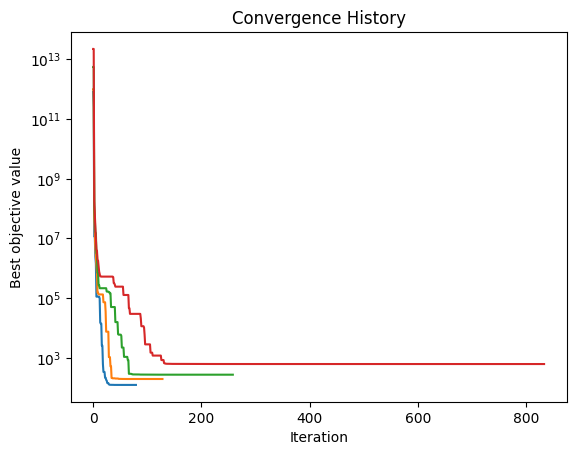

In [41]:
# Minimize loss function
i = 0
for ky1 in ins_dict.keys():
    X_lcl = np.array(ins_dict[ky1]['Samples'])
    Y_lcl = np.array(ins_dict[ky1]['Actuals'])
    W_lcl = np.array(ins_dict[ky1]['Weights'])
    wrm_start_lcl = get_warm_start_linreg(x = X_lcl[:,features[i]], y = Y_lcl, w = W_lcl, indx=i).flatten()
    
    lmbds = dict_methods[ky1]['Regularized Linear Regression']['Lambdas'][0]
    args_RLR = (X_lcl, Y_lcl, W_lcl, i, lmbds[0], lmbds[1], lmbds[2], 'all')
    ins_dict[ky1]['history'], ins_dict[ky1]['sol_RLR_lcl'] = optimize_with_tracking(lss_all_input, wrm_start_lcl, lss_all_jac_input, args_f = args_RLR)

    # Access the best solution found
    print(f"Best value found: {ins_dict[ky1]['history'].best_fun}")
    print(f"Best position found [:10]: {ins_dict[ky1]['history'].best_x[:10]}")

    # Plot the convergence history
    pyplt.plot(ins_dict[ky1]['history'].all_best_values)
    pyplt.xlabel('Iteration')
    pyplt.ylabel('Best objective value')
    pyplt.yscale('log')
    pyplt.title('Convergence History')

    i = i + 1


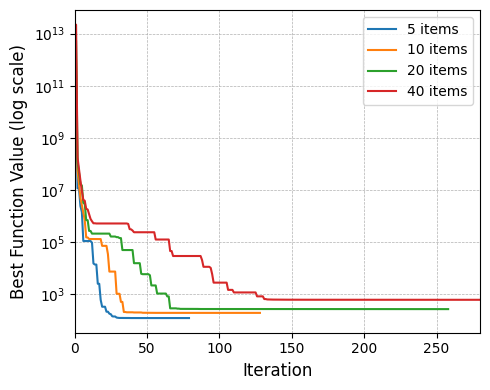

In [42]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = ins_dict.keys()

pyplt.figure(figsize=(5, 4))
i =0
for ky1 in ins_dict.keys():
    pyplt.plot(ins_dict[ky1]['history'].all_best_values, color=colors[i], label=ky1)
    i = i + 1

pyplt.yscale('log')
pyplt.xlim(left =0, right=280)
pyplt.xlabel("Iteration", fontsize=12)
pyplt.ylabel("Best Function Value (log scale)", fontsize=12)
# pyplt.title("Convergence History", fontsize=14, fontweight='bold')
pyplt.grid(True, which='both', linestyle='--', linewidth=0.5)
pyplt.legend(loc='upper right')
pyplt.tight_layout()
pyplt.show()

In [44]:
i = 0
for ky1 in ins_dict.keys():
    print(ky1)
    X_lcl = np.array(ins_dict[ky1]['Samples'])
    Y_lcl = np.array(ins_dict[ky1]['Actuals'])
    W_lcl = np.array(ins_dict[ky1]['Weights'])
    start = time.time()
    wrm_start_lcl = get_warm_start_linreg(x = X_lcl[:,features[i]], y = Y_lcl, w = W_lcl, indx=i).flatten()
    end = time.time()
    time_SLR = end - start

    for method in dict_methods[ky1].keys():
        if method == 'Regularized Linear Regression':
            method_times = {}
            for m in methods:
                print(m)
                rgn   = dict_methods[ky1][method]['Region'][0]
                lmbds = dict_methods[ky1][method]['Lambdas'][0]
                ins_dict[ky1][method] = {}

                args_RLR = (X_lcl, Y_lcl, W_lcl, i, lmbds[0], lmbds[1], lmbds[2], rgn)
                start = time.time()
                sol_RLR_lcl = minimize(lss_all_input, wrm_start_lcl, args = args_RLR, method=m, jac = lss_all_jac_input, options = {'maxiter': 1000})
                end = time.time()
                # print(sol_RLR_lcl)
                time_RLR = end - start
                method_times[m] = (time_RLR, sol_RLR_lcl.fun)
            
        else:
             continue  # Skip other methods for now
    break

5 items
Nelder-Mead


C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_33324\2936094237.py:23: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  sol_RLR_lcl = minimize(lss_all_input, wrm_start_lcl, args = args_RLR, method=m, jac = lss_all_jac_input, options = {'maxiter': 1000})


Powell


C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_33324\2936094237.py:23: RuntimeWarning: Method Powell does not use gradient information (jac).
  sol_RLR_lcl = minimize(lss_all_input, wrm_start_lcl, args = args_RLR, method=m, jac = lss_all_jac_input, options = {'maxiter': 1000})


CG
BFGS
Newton-CG
L-BFGS-B
TNC


C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_33324\2936094237.py:23: OptimizeWarning: Unknown solver options: maxiter
  sol_RLR_lcl = minimize(lss_all_input, wrm_start_lcl, args = args_RLR, method=m, jac = lss_all_jac_input, options = {'maxiter': 1000})


COBYLA


C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_33324\2936094237.py:23: RuntimeWarning: Method COBYLA does not use gradient information (jac).
  sol_RLR_lcl = minimize(lss_all_input, wrm_start_lcl, args = args_RLR, method=m, jac = lss_all_jac_input, options = {'maxiter': 1000})


COBYQA


C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_33324\2936094237.py:23: RuntimeWarning: Method COBYQA does not use gradient information (jac).
  sol_RLR_lcl = minimize(lss_all_input, wrm_start_lcl, args = args_RLR, method=m, jac = lss_all_jac_input, options = {'maxiter': 1000})


SLSQP
trust-constr


### Descent methods

In [45]:
for key in method_times.keys():
    print(f'{key}, {method_times[key][0]:.2E} seconds. Training loss: {method_times[key][1]:.2E}')

Nelder-Mead, 9.96E+00 seconds. Training loss: 1.36E+02
Powell, 2.31E+02 seconds. Training loss: 1.25E+02
CG, 8.37E+01 seconds. Training loss: 1.24E+02
BFGS, 1.86E+01 seconds. Training loss: 1.23E+02
Newton-CG, 3.86E+02 seconds. Training loss: 1.24E+02
L-BFGS-B, 8.67E+01 seconds. Training loss: 1.23E+02
TNC, 7.76E+01 seconds. Training loss: 1.23E+02
COBYLA, 9.61E+00 seconds. Training loss: 1.38E+02
COBYQA, 8.99E+01 seconds. Training loss: 1.35E+02
SLSQP, 1.03E+01 seconds. Training loss: 1.23E+02
trust-constr, 1.10E+02 seconds. Training loss: 1.23E+02
